<a href="https://colab.research.google.com/github/jhermosillo/diplomado_CDD2019/blob/master/04%20Clasificacion_Agrupamiento/1%20Modelos%20Lineales/Notebooks/Regresion_Lineal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table >
  <thead>
  <tr>
    <th colspan="2"><img src="../img/data_science_rec.jpg" width="100%"/></th>
  </tr>
  <tr>
    <td><font size="6"><p style="text-align:left;"><b>Diplomado en <br>Ciencia de Datos con Python</b></p></font></td>
    <td width="13%"><img src="../img/uaem.jpg"/></td>
  </tr>
  <tr>
      <td><font size="7">Regresión Lineal ("revisited")</font></td>
    <td width="13%"><img src="../img/logoCInC.jpg" /></td>
  </tr>
  </thead>
</table>


##  &#9991; Regresión Lineal: clases y código propuestos por Bishop

&#128214; <u>Referencias bibliográficas</u>:
* Bishop, Christopher M. (2006). Pattern recognition and machine learning. New York. Springer.

* Los modelos de regresión lineal se pueden expresar como:

$$
y(\textrm{x},\textrm{w})=w_0+\sum_{j=1}^{M-1}w_j\phi_j(\textrm{x})
$$

Donde a las $\phi_j(\textrm{x})$ se les conoce como funciones base o `features`.

___

### Funciones base polinomiales

In [20]:
import itertools
import functools
import numpy as np


class PolynomialFeature(object):
    """
    polynomial features

    transforms input array with polynomial features

    Example
    =======
    x =
    [[a, b],
    [c, d]]

    y = PolynomialFeatures(degree=2).transform(x)
    y =
    [[1, a, b, a^2, a * b, b^2],
    [1, c, d, c^2, c * d, d^2]]
    """

    def __init__(self, degree=2):
        """
        construct polynomial features

        Parameters
        ----------
        degree : int
            degree of polynomial
        """
        assert isinstance(degree, int)
        self.degree = degree

    def transform(self, x):
        """
        transforms input array with polynomial features

        Parameters
        ----------
        x : (sample_size, n) ndarray
            input array

        Returns
        -------
        output : (sample_size, 1 + nC1 + ... + nCd) ndarray
            polynomial features
        """
        if x.ndim == 1:
            x = x[:, None]
        x_t = x.transpose()
        features = [np.ones(len(x))]
        for degree in range(1, self.degree + 1):
            for items in itertools.combinations_with_replacement(x_t, degree):
                features.append(functools.reduce(lambda x, y: x * y, items))
        return np.asarray(features).transpose()


Información de [python functools](https://docs.python.org/3/library/functools.html)

**`functools.reduce(function, iterable[, initializer])`**

Apply function of two arguments cumulatively to the items of iterable, from left to right, so as to reduce the iterable to a single value. For example, reduce(lambda x, y: x+y, [1, 2, 3, 4, 5]) calculates ((((1+2)+3)+4)+5). The left argument, x, is the accumulated value and the right argument, y, is the update value from the iterable. If the optional initializer is present, it is placed before the items of the iterable in the calculation, and serves as a default when the iterable is empty. If initializer is not given and iterable contains only one item, the first item is returned.

___

### Funciones base Gaussianas

$$
\phi_j(x)=\exp\left\{-\frac{(x-\mu_j)^2}{2s^2}\right\}
$$

donde $\mu_j$ gobierna las ubicaciones de las funciones base en el espacio de entrada y el parámetro $s$ gobierna su escala espacial. 

* No ncesariamente tienen una interpretación probabilística. 

In [21]:
class GaussianFeature():
    """
    Gaussian feature

    gaussian function = exp(-0.5 * (x - m) / v)
    """

    def __init__(self, mean, var):
        """
        construct gaussian features

        Parameters
        ----------
        mean : (n_features, ndim) or (n_features,) ndarray
            places to locate gaussian function at
        var : float
            variance of the gaussian function
        """
        if mean.ndim == 1:
            mean = mean[:, None]
        else:
            assert mean.ndim == 2
        assert isinstance(var, float) or isinstance(var, int)
        self.mean = mean
        self.var = var

    def _gauss(self, x, mean):
        return np.exp(-0.5 * np.sum(np.square(x - mean), axis=-1) / self.var)

    def transform(self, x):
        """
        transform input array with gaussian features

        Parameters
        ----------
        x : (sample_size, ndim) or (sample_size,)
            input array

        Returns
        -------
        output : (sample_size, n_features)
            gaussian features
        """
        if x.ndim == 1:
            x = x[:, None]
        else:
            assert x.ndim == 2
        assert np.size(x, 1) == np.size(self.mean, 1)
        basis = [np.ones(len(x))]
        for m in self.mean:
            basis.append(self._gauss(x, m))
        return np.asarray(basis).transpose()


___

### Funciones base sigmoidales

$$
\phi_j(x)=\sigma\left(\frac{x-\mu_j}{s}\right)
$$

donde

$$
\sigma(a)=\frac{1}{1+\exp(a)}
$$

In [23]:
class SigmoidalFeature(object):
    """
    Sigmoidal features

    1 / (1 + exp((m - x) @ c)
    """

    def __init__(self, mean, coef=1):
        """
        construct sigmoidal features

        Parameters
        ----------
        mean : (n_features, ndim) or (n_features,) ndarray
            center of sigmoid function
        coef : (ndim,) ndarray or int or float
            coefficient to be multplied with the distance
        """
        if mean.ndim == 1:
            mean = mean[:, None]
        else:
            assert mean.ndim == 2
        if isinstance(coef, int) or isinstance(coef, float):
            if np.size(mean, 1) == 1:
                coef = np.array([coef])
            else:
                raise ValueError("mismatch of dimension")
        else:
            assert coef.ndim == 1
            assert np.size(mean, 1) == len(coef)
        self.mean = mean
        self.coef = coef

    def _sigmoid(self, x, mean):
        return np.tanh((x - mean) @ self.coef * 0.5) * 0.5 + 0.5

    def transform(self, x):
        """
        transform input array with sigmoidal features

        Parameters
        ----------
        x : (sample_size, ndim) or (sample_size,) ndarray
            input array

        Returns
        -------
        output : (sample_size, n_features) ndarray
            sigmoidal features
        """
        if x.ndim == 1:
            x = x[:, None]
        else:
            assert x.ndim == 2
        assert np.size(x, 1) == np.size(self.mean, 1)
        basis = [np.ones(len(x))]
        for m in self.mean:
            basis.append(self._sigmoid(x, m))
        return np.asarray(basis).transpose()

### Ilustración de las features

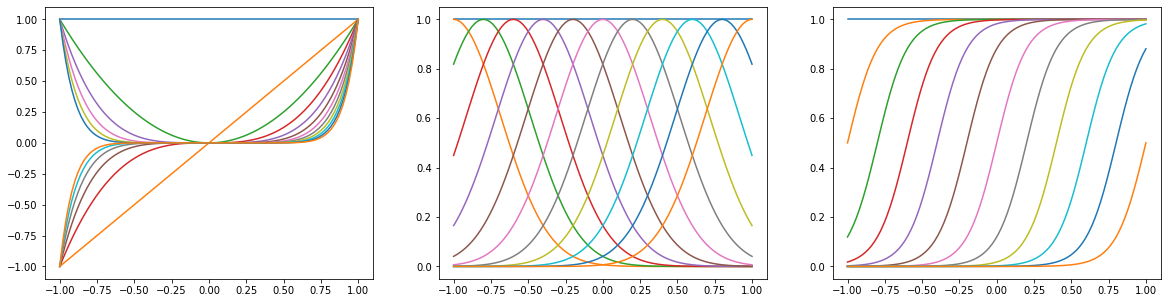

In [24]:
x = np.linspace(-1, 1, 100)
X_polynomial = PolynomialFeature(11).transform(x[:, None])
X_gaussian = GaussianFeature(np.linspace(-1, 1, 11), 0.1).transform(x)
X_sigmoidal = SigmoidalFeature(np.linspace(-1, 1, 11), 10).transform(x)

plt.figure(figsize=(20, 5))
for i, X in enumerate([X_polynomial, X_gaussian, X_sigmoidal]):
    plt.subplot(1, 3, i + 1)
    for j in range(12):
        plt.plot(x, X[:, j])

### Regresión Lineal con múltiples instancias (matriz de datos $X$): regresión tipo "Batch".

* Cada instancia de entrenamiento $\textrm{x}_n$ puede transformarse en $\phi(\textrm{x}_n)$ 

$$
\textrm{w}=(X^\textrm{T}X)^{-1}X^{\textrm{T}}\mathbf{t}
$$

donde $\mathbf{t}$ es la variable objetivo (target).

* La matriz $X^\dagger=(X^\textrm{T}X)^{-1}X^{\textrm{T}}$ se conoce como la _pseudo inversa de Moore-Penrose_.
* en Python se puede calcular usando [numpy.linalg.pinv](https://numpy.org/doc/stable/reference/generated/numpy.linalg.pinv.html?highlight=moore%20penrose).


In [27]:
class LinearRegression():
    """
    Linear regression model
    y = X @ w
    t ~ N(t|X @ w, var)
    """

    def fit(self, X:np.ndarray, t:np.ndarray):
        """
        perform least squares fitting

        Parameters
        ----------
        X : (N, D) np.ndarray
            training independent variable
        t : (N,) np.ndarray
            training dependent variable
        """
        self.w = np.linalg.pinv(X) @ t
        self.var = np.mean(np.square(X @ self.w - t))

    def predict(self, X:np.ndarray, return_std:bool=False):
        """
        make prediction given input

        Parameters
        ----------
        X : (N, D) np.ndarray
            samples to predict their output
        return_std : bool, optional
            returns standard deviation of each predition if True

        Returns
        -------
        y : (N,) np.ndarray
            prediction of each sample
        y_std : (N,) np.ndarray
            standard deviation of each predition
        """
        y = X @ self.w
        if return_std:
            y_std = np.sqrt(self.var) + np.zeros_like(y)
            return y, y_std
        return y


## Máximo de verosimilitud y Mínimos Cuadrados

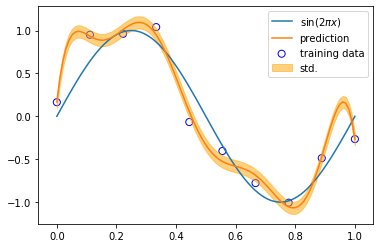

In [28]:
def sinusoidal(x):
    return np.sin(2 * np.pi * x)

x_train, y_train = create_toy_data(sinusoidal, 10, 0.25)
x_test = np.linspace(0, 1, 100)
y_test = sinusoidal(x_test)

# Pick one of the three features below
# feature = PolynomialFeature(8)
feature = GaussianFeature(np.linspace(0, 1, 8), 0.1)
# feature = SigmoidalFeature(np.linspace(0, 1, 8), 10)

X_train = feature.transform(x_train)
X_test = feature.transform(x_test)
model = LinearRegression()
model.fit(X_train, y_train)
y, y_std = model.predict(X_test, return_std=True)

plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(x_test, y_test, label="$\sin(2\pi x)$")
plt.plot(x_test, y, label="prediction")
plt.fill_between(
    x_test, y - y_std, y + y_std,
    color="orange", alpha=0.5, label="std.")
plt.legend()
plt.show()

___

##  &#9991; Regresión Lineal usando scikit-learn

* Módulo de Regresión Lineal: [sklearn.linear_model.LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
* Métricas de error de regresión: [sklearn.metrics.mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) y [sklearn.metrics.r2_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html)
* Funciones base (features): [sklearn.preprocessing.PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)

In [9]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

### Datos con ruido

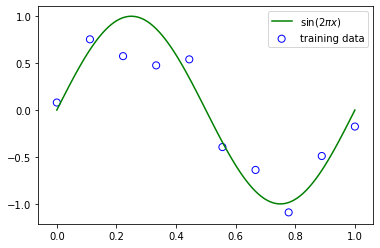

In [2]:
def create_toy_data(func, sample_size, std):
    x = np.linspace(0, 1, sample_size)
    t = func(x) + np.random.normal(scale=std, size=x.shape)
    return x, t

def func(x):
    return np.sin(2 * np.pi * x)

x_train, y_train = create_toy_data(func, 10, 0.25)
x_test = np.linspace(0, 1, 100)
y_test = func(x_test)

plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(x_test, y_test, c="g", label="$\sin(2\pi x)$")
plt.legend()
plt.show()

### Entrenamiento y prueba del modelo

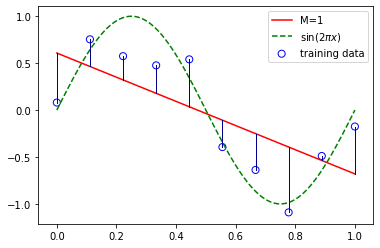

In [3]:
# transforming the data to include another axis
x = x_train[:, np.newaxis]
y = y_train[:, np.newaxis]

model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)

plt.scatter(x, y, facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(x, y_pred, color='r',label="M=1")
plt.plot(x_test, y_test, c="g", ls='--', label="$\sin(2\pi x)$")
plt.plot(np.vstack([x_train,x_train]), np.vstack([y_train, y_pred.ravel()]), color="darkblue",lw=1);
plt.legend()
plt.show()

### Recuperación de los parámetros del modelo

In [4]:
print("Parametros del modelo:    ", model.coef_)
print("W0:  ", model.intercept_)

Parametros del modelo:     [[-1.28781973]]
W0:   [0.6078135]


### Evaluación del error

In [6]:
rmse = np.sqrt(mean_squared_error(y,y_pred))
r2 = r2_score(y,y_pred)
print(rmse)  # 0 es el ideal
print(r2)    # 1 es el ideal


0.41755485938074344
0.4920866706744985


### Nueva regresión mediante funciones base (features) polinomiales de grado 3

RMSE= 0.17731428718157252
R^2= 0.9084095934415661
Parametros del modelo:     [  0.08   7.52 -23.4   15.67]


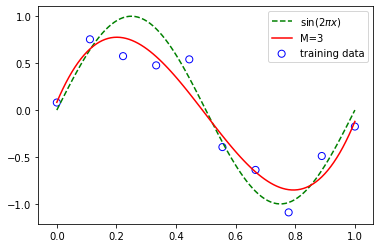

In [10]:
polynomial_features= PolynomialFeatures(degree=3)
x_poly = polynomial_features.fit_transform(x)

x_poly_test = polynomial_features.fit_transform(x_test[:, np.newaxis])

model = LinearRegression()
model.fit(x_poly, y)

y_poly_pred = model.predict(x_poly)

y_poly_test = model.predict(x_poly_test)

rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
r2 = r2_score(y,y_poly_pred)

np.set_printoptions(suppress=True,precision=2)

print('RMSE=',rmse)
print('R^2=',r2)
ws= model.coef_.ravel()
ws[0]=model.intercept_[0]
print("Parametros del modelo:    ",ws)

plt.scatter(x, y, facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(x_test, y_test, c="g", ls='--', label="$\sin(2\pi x)$")
plt.plot(x_test, y_poly_test, color='r',label="M=3")
plt.legend()
plt.show()

### Nueva regresión con features polinomiales de grado 9

7.461044308817295e-11
1.0
Parametros del modelo:     [      0.16     186.41   -4133.29   36515.15 -168167.46  449523.42
 -724806.18  695411.04 -365505.95   80977.11]


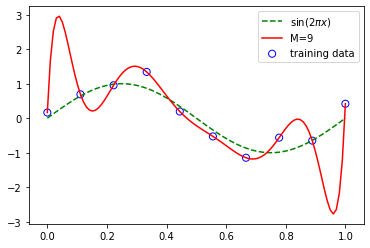

In [11]:
x_train, y_train = create_toy_data(func, 10, 0.25)
x_test = np.linspace(0, 1, 100)
y_test = func(x_test)

x = x_train[:, np.newaxis]
y = y_train[:, np.newaxis]

polynomial_features= PolynomialFeatures(degree=9)
x_poly = polynomial_features.fit_transform(x)

x_poly_test = polynomial_features.fit_transform(x_test[:, np.newaxis])

model = LinearRegression()
model.fit(x_poly, y)

y_poly_pred = model.predict(x_poly)

y_poly_test = model.predict(x_poly_test)

rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
r2 = r2_score(y,y_poly_pred)

np.set_printoptions(suppress=True,precision=2)

print(rmse)
print(r2)
ws= model.coef_.ravel()
ws[0]=model.intercept_[0]
print("Parametros del modelo:    ",ws)

plt.scatter(x, y, facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(x_test, y_test, c="g", ls='--', label="$\sin(2\pi x)$")
plt.plot(x_test, y_poly_test, color='r',label="M=9")
plt.legend()
plt.show()

x_nReg=x_test
y_nReg=y_poly_test

### Efecto de la regularización L2: "Ridge Regression", "norma L2". "Ridge" (cresta); se trata de minimizar la cresta que representa un vector de pesos muy grande.
* Si el error de regresión sobre los datos es $E_D(\textrm{w})$, y la cresta es $E_W(\textrm{w})=\frac{1}{2}\textrm{w}^\textrm{T}\textrm{w}=\frac{1}{2}\left\lVert\textrm{w}\right\rVert^2$, se busca minimizar:

$$
E_D(\textrm{w})+\frac{\lambda}{2}\left\lVert\textrm{w}\right\rVert^2
$$
* Utilizaremos el módulo de regresión lineal [sklearn.linear_model.Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html).

In [12]:
from sklearn.linear_model import Ridge


alpha1=1.0 #ln alpha=0
alpha2=1.57E-8 #ln alpha = -18
alpha3=1.0E-20   #ln alpha = -inf

clf = Ridge(alpha=alpha2)
clf.fit(x_poly, y)
y_poly_pred = clf.predict(x_poly)

y_poly_test = clf.predict(x_poly_test)

rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
rr2 = clf.score(x_poly,y)

print('RMSE=',rmse,'R^2=',rr2)

RMSE= 0.12171389203366718 R^2 0.9739413432101045


[   0.      2.63    5.35   99.19 -521.84  439.35  487.1  -308.72 -685.92
  483.09]


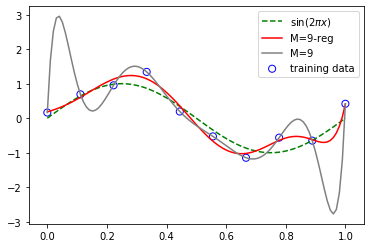

In [15]:
ws=clf.coef_.ravel()
print(ws)

plt.scatter(x, y, facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(x_test, y_test, c="g", ls='--', label="$\sin(2\pi x)$")
plt.plot(x_test, y_poly_test, color='r',label="M=9-reg")
plt.plot(x_nReg, y_nReg, color='gray',label="M=9")
plt.legend()
plt.show()

### Efecto de la regularización L1: "Lasso Regression", "norma L1". LASSO:  Least Absolute Selection and Shrinkage Operator. 
* En este caso, se busca minimizar:

$$
E_D(\textrm{w})+\lambda\left\lvert\textrm{w}\right\rvert
$$
* Utilizaremos el módulo de regresión lineal [sklearn.linear_model.Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html).

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012563878320309141, tolerance: 0.0005684971268253387
  positive)


[  0.     5.43 -13.45   0.     3.06   5.33   0.     0.    -0.    -0.23]


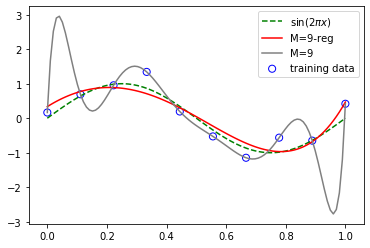

In [17]:
from sklearn.linear_model import Lasso

reg = Lasso(alpha=0.001)

reg.fit(x_poly, y)
y_poly_pred = reg.predict(x_poly)

y_poly_test = reg.predict(x_poly_test)

ws=reg.coef_.ravel()
print(ws)

plt.scatter(x, y, facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(x_test, y_test, c="g", ls='--', label="$\sin(2\pi x)$")
plt.plot(x_test, y_poly_test, color='r',label="M=9-reg")
plt.plot(x_nReg, y_nReg, color='gray',label="M=9")
plt.legend()
plt.show()

___

### Regresión Lineal por descenso de gradiente

* La regresión lineal con grandes cantidades de datos puede ser muy costosa en términos de recursos de cómputo.
* Una alternativa es hacer regresión por Descenso Estocástico de Gradiente (Stochastic Gradient Descent - SGD).
* En este caso, los pesos se actualizan en cada iteración de la siguiente forma:
$$
\textrm{w}^{(\tau+1)}=\textrm{w}^{(\tau)}-\eta\nabla E
$$

donde $\tau$ es el número de iteración y $\eta$ es el parámetro de la tasa de aprendizaje. El valor de $\textrm{w}$ se inicializa en algún valor $\textrm{w}_0$ arbitrario. 

* Para el caso en el que la función de error es $E_D(\textrm{w})=\frac{1}{2}\sum_{n=1}^{N} \{t_n - \textrm{w}^\textrm{T}\phi(\textrm{x}_n)\}^2$, 

$$
\textrm{w}^{(\tau+1)}=\textrm{w}^{(\tau)}-\eta(t_n - \textrm{w}^\textrm{T}\phi_n)\phi_n
$$

donde $\phi_n=\phi(\textrm{x}_n)$.

* A este algoritmo se le conoce como _Least Mean Squares_ (LSM).

___

&#9998; **Usa [sklearn.linear_model.SGDRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html) para probarlo.**

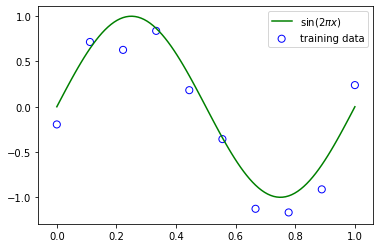

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline

""" TU CÓDIGO AQUÍ """


"""----------------"""
x_train, y_train = create_toy_data(func, 10, 0.25)
x_test = np.linspace(0, 1, 100)
y_test = func(x_test)

plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(x_test, y_test, c="g", label="$\sin(2\pi x)$")
plt.legend()
plt.show()